## Analyze A/B Test Results: Study Project

### Lyubomira Derelieva
### January 2023

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project uses three methods (probability, A/B testing and a regression model) to test whether an e-commerce new website landing page leads to more users converting into members than their current ('old') page.

In addition, the project will test whether a user's country of residence has an effect on conversion.



<a id='probability'></a>
#### Part I - Probability



This section will use probability to test the effect of the landing page on conversion.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# read dataset

df = pd.read_csv('ab_data.csv')


In [3]:
# visualy explore dataset

df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# visualy explore dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# find the number of unique users in the dataset

df.user_id.nunique()

290584

In [6]:
# find the proportion of users who converted

df.converted.mean()

0.11965919355605512

In [7]:
# find the number of times the new_page and treatment don't line up
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [8]:
# check for missing values

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# delete rows where the 'treatment' and 'new page' values don't match

df2 = df.drop(df.query("group=='treatment' & landing_page == 'old_page' or group=='control' & landing_page=='new_page'").index)


In [10]:
# check results

df2.head(100)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
96,894540,2017-01-04 03:38:35.794542,treatment,new_page,0
97,939580,2017-01-09 08:23:14.945700,control,old_page,0
98,698331,2017-01-22 21:14:30.175017,control,old_page,0
99,631524,2017-01-10 07:08:26.627109,treatment,new_page,0


In [11]:
# double check all of the correct rows were removed - this should be 0

df2.query("group=='treatment' and landing_page=='old_page'").shape[0]

0

In [12]:
# find the number of unique user_ids are in df2

df2.user_id.nunique()

290584

In [13]:
# find repeated user_ids

df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# remove one of the duplicates

df2.drop(1899, inplace = True)

In [15]:
# check the duplicate has been deleted

df2.duplicated().sum()


0

In [16]:
# find the probability of an individual converting regardless of the page they receive

df2.converted.mean()

0.11959708724499628

In [17]:
# find the probability of a control group individual converting

df2.query("group == 'control'").converted.mean()

0.1203863045004612

In [18]:
# find the probability of a treatment group individual converting

df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

In [19]:
# first, create a new column new_page with Boolean values to allow calculating the mean

df2['new_page'] = (df2.landing_page == 'new_page')


In [20]:
# check results

df2.head()

,user_id,timestamp,group,landing_page,converted,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False


In [21]:
# find the probability that an individual received the new page

df2.new_page.mean()

0.5000619442226688

## Is there sufficient evidence to say that the new treatment page leads to more conversions?

>Our null hypothesis is that the probability of converting is the same or higher for participants in the control group who see the old landing page.

>The alternative hypothesis is that the probability of converting is higher for participants in the treatment group who see the new landing page.

>We see that the probability of converting for individuals in the treatment group is lower than for individuals in the control group (0.1188 < 0.1203). Based on these results, we fail to reject the null hypothesis and we keep the old landing page.

<a id='ab_test'></a>
### Part II - A/B Test



This section will use A/B testing to investigate the effect of the landing page on conversion.

Our **null hypothesis** is that the probability of converting is the same or higher for participants in the control group who see the old landing page (H0: Pold ≥ Pnew).

The **alternative hypothesis** is that the probability of converting is higher for participants in the treatment group who see the new landing page (H1: Pold < Pnew).

Given a Type I error rate of 5%, we set the level of significance at 0.05.

In [22]:
# find the conversion rate p_new under the null
p_new = 0.11959708724499628


In [23]:
# find the conversion rate p_old under the null

p_old = 0.11959708724499628


In [24]:
# calculate the number of individuals in the treatment group (n_new)

n_new = df2[df2.group=='treatment'].user_id.count()
n_new


145310

In [25]:
# calculate the number of individuals in the control group (n_old)

n_old = df2[df2.group=='control'].user_id.count()
n_old


145274

In [26]:
# simulate n_new transactions with a conversion rate of p_new under the null and store them as 0s and 1s in a df

new_page_converted = np.random.choice([0,1], size = n_new, p = [p_new, 1-p_new])


In [27]:
# simulate n_old transactions with a conversion rate of p_old under the null and store them as 0s and 1s in a df

old_page_converted = np.random.choice([0,1], size = n_old, p = [p_old, 1-p_old])


In [28]:
# find the difference in probability for p_new and p_old under the null

diff_p_null = new_page_converted.mean() - old_page_converted.mean()
diff_p_null


0.0018945938106690319

In [29]:
# simulate 10,000 p_new - p_old values and store them in a new df

new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation


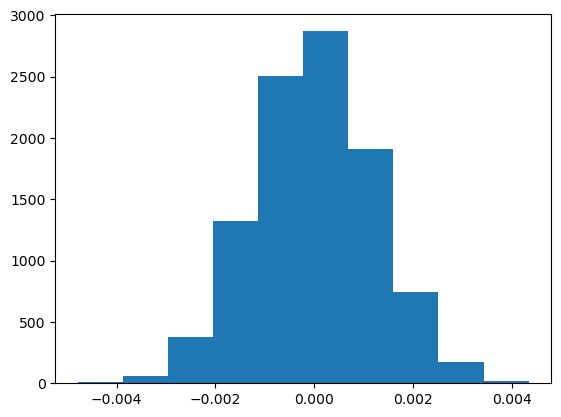

In [30]:
# plot the df on a histogram

plt.hist(p_diffs);


In [31]:
# calculate the proportion of p_diffs greater than the actual difference observed in ab_data

obs_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
(p_diffs > obs_diff).mean()


0.9034

The 0.9 result is our **p value**. It expresses the likelihood that we would have obtained these results if the null hypothesis were true. 

Given such a high p value, the deviation from the null hypothesis is not statistically significant and we **fail to reject the null hypothesis**. We will **keep the old landing page**.


###  Repeat test using a built-in model 

In [32]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = n_old
n_new = n_new

In [33]:
# use a one proportion z-test to compare the observed proportion to the theoretical one

count = np.array([convert_new,convert_old])
nobs = np.array([n_new,n_old])
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245



To determine whether the z-score is significant, we need to compare it to a z-critical value.

In [34]:
# import scipy library
import scipy.stats

# define probability
p = 0.95   

# find the z-critical value
scipy.stats.norm.ppf(p)


1.6448536269514722

As the z-score (-1.31) is smaller than the z-critical value (1.64), it is less significant, so we fail to reject the null hypothesis again. 

<a id='regression'></a>
### Part III - A regression approach


This section will use **logistic regression** to test the effect of the landing page on conversion.



In [35]:
# create a column for the intercept

df2['intercept'] = 1


In [36]:
# add an ab_page column, where 1 == treatment and 0 == control

df2['ab_page'] = df2['landing_page'].map({'new_page': 1, 'old_page': 0})


In [37]:
# check result

df2.head()


,user_id,timestamp,group,landing_page,converted,new_page,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,True,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,True,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


In [38]:
# import regression model and fit it to predict whether an individual will convert or not

df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [39]:
# show the results summary

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:               8.077e-06
Time:                        13:24:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with the coefficient ab_page is 0.19 (> 0.05). This suggests that the result is not statistically significant, so our model suggests that the new page doesn't influence conversion. Therefore, we fail to reject the null hypothesis. 

Although it confirms the conclusion in Part II, the p-value differs because the regression software returns a 2-tailed test of the null hypothesis by default. Thus, it tests whether the conversion rates for the two pages are **different** regardless of which one is better.

This means that the null hypothesis = there is no difference in conversion between the old and the new pages (the coefficient = 0), and the alternative hypothesis = there is a difference in conversion rates between the old and the new pages (the coefficient ≠ 0).

Conversely, the test in Part II is a 1-tailed test. We wanted to test whether the new page conversion rates are **higher** than the old page's. 


It may be a good idea to consider adding more factors to a regression model to find more important potential influences and thus increase the model's predictive power.

Possible disadvantages to adding extra terms into a regression model may be that:

- the model would become too complex (overfitting) and produce misleading r-squared values, regression coefficients, and p-values.
-  a variable can increase the variance of other correlation coefficients. 
- an overfitted model would be less generalizable, i.e. it would not fit different random samples drawn from the population.

Source:  https://statisticsbyjim.com/regression/overfitting-regression-models/

- there is a higher risk that the predictor variables are correlated with one another (multicollinearity).

Source: lesson on multicollinearity and VIFs

To see this, let's examine the landing page effect based on the country in which a user lives.



### Effect of User Country of Residence

In [49]:
# create a new the dataframe
countries_df = pd.read_csv('./countries.csv')


In [41]:
# find the countries in the dataset

countries_df.country.unique()


array(['UK', 'US', 'CA'], dtype=object)

In [42]:
# visually explore the dataset

countries_df.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# create the necessary dummy variables

countries_df[['UK', 'US', 'CA']] = pd.get_dummies(countries_df['country'])


In [44]:
# check result

countries_df.head()


,user_id,country,UK,US,CA
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [45]:
# join the two dataframes

df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')


In [46]:
#check result

df_new.head()


,country,UK,US,CA,timestamp,group,landing_page,converted,new_page,intercept,ab_page
user_id,,,,,,,,,,,
834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,False,1,0
928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,True,1,1
822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,True,1,1
711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,False,1,0
710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,True,1,1


In [47]:
### fit the linear model and obtain the results

df_new['intercept'] = 1
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results_new = logit_mod.fit()
results_new.summary()




Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:               1.521e-05
Time:                        13:24:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US             0.0099      0.013      0.746      0.456      -0.016       0.036
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [48]:
# introduce interaction terms 

df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']
logit3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])

results_new = logit3.fit()
results_new.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:               3.482e-05
Time:                        13:24:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

The p-values for both the UK and the US interaction terms with ab_page are above the threshold of > 0.05, meaning that the interaction between country and conversion is not statistically significant. Therefore, we can conclude that **the country parameter has no statistically significant effect on conversion**.

<a id='conclusions'></a>
## Conclusions

The project's conclusions are that there is no evidence that:

- the new landing page leads to more user conversions, so we can keep the old page, and that
- user's country of residence affects conversion.

